# Heart Failure Death Classification dataset

## Code

In [29]:
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from functools import partial
from sklearn import tree

## Sort data

In [30]:
#sort data
heart_failure_data = pd.read_csv("./Heart failure data/heart_failure_clinical_records_dataset.csv")
heart_failure_data
##as for cleaning,the features are relevant to the entire dataset.

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


## What the data looks like after cleaning

In [31]:
print(heart_failure_data['DEATH_EVENT'].value_counts())
heart_failure_data
##for now, the imbalance between the death events occuring (1, 203) versus not occuring (0,203) is fine. we will see how the model 
## performs to show that.

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [32]:
#get X,Y for sake of training later.
XY = heart_failure_data.values
X = XY[:,:-1]
y = XY[:,-1]
XY.shape




(299, 13)

## Partition data sets, visualize dataset partitions for sanity check!

In [33]:
#Data partitions (0.8/0.2 training-data, 0.5/0.5 training-to-data, 0.2/0.8 training-to-data)


#80-20 split
Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#50-50 split
Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#20-80 split
Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [34]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == 0).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1],
                c='blue', label='no death event')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1],
                c='red', label='death')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

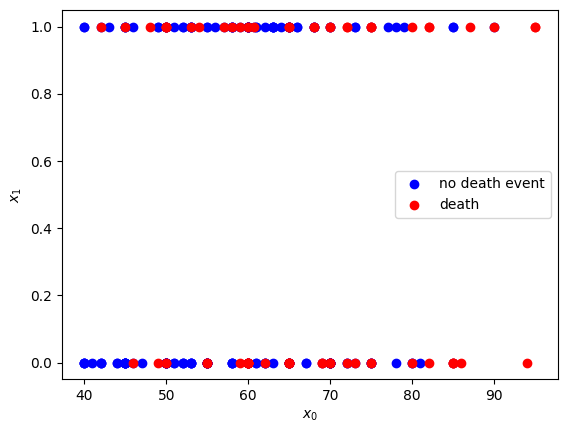

In [35]:
#more visualization
#Visualize training set as a sanity check; classes (0,1) are being plotted.
vis(Split1X_train, Split1y_train)

# Classifiers

## Partition: 80/20 set

Partition: 0.8
Train Accuracy: 0.8535564853556485
Validation Accuracy: 0.8532608695652174


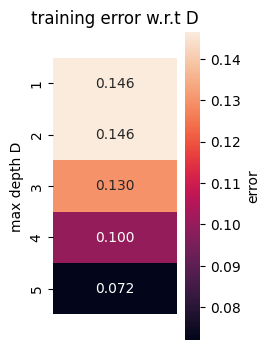

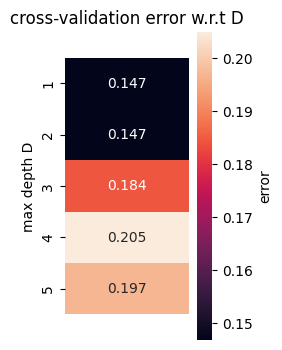

Best max depth D: 1
Test error: 0.18333333333333335
Train Accuracy: 0.8410041841004184
Validation Accuracy: 0.8409420289855072


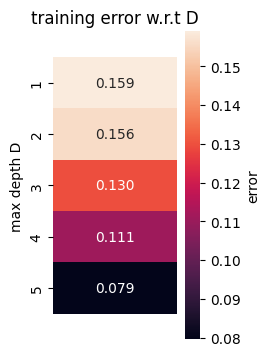

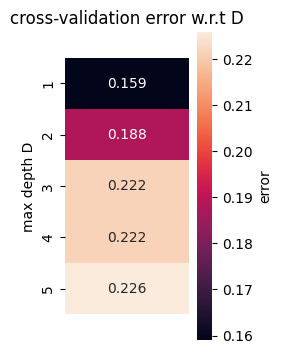

Best max depth D: 1
Test error: 0.1333333333333333
Train Accuracy: 0.8326359832635983
Validation Accuracy: 0.8242753623188405


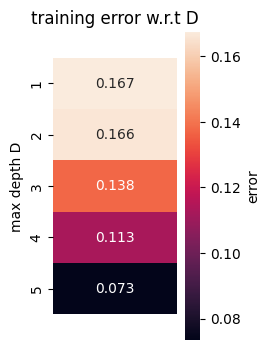

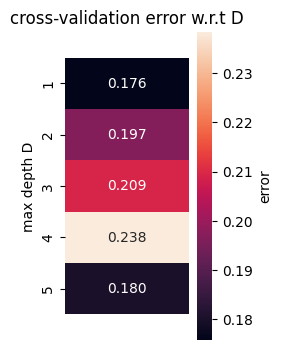

Best max depth D: 1
Test error: 0.09999999999999998


In [36]:
### Decision Tree ###
DTtestAccuracy_List1=[]
DTtestAccuracy_ListOverall = []
partitions = [0.8]
DTbest_max_depth_overall = 0
DT_best_accuracy = 0
trial = 3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split1X_train, Split1y_train)
        DTtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))


Partition: 0.8
Train Accuracy: 0.9581589958158996
Validation Accuracy: 0.8702898550724638


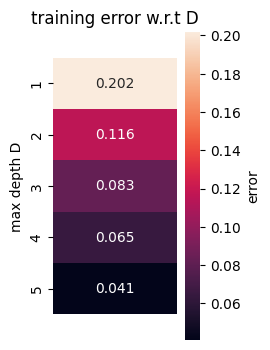

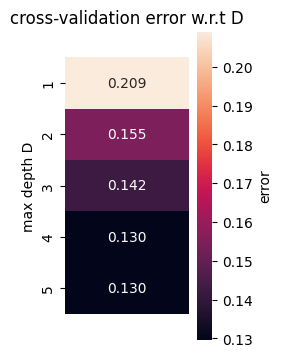

Best max depth D: 5
Test error: 0.2833333333333333
Train Accuracy: 0.9539748953974896
Validation Accuracy: 0.866123188405797


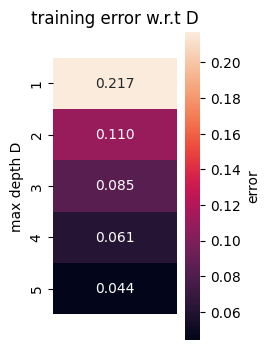

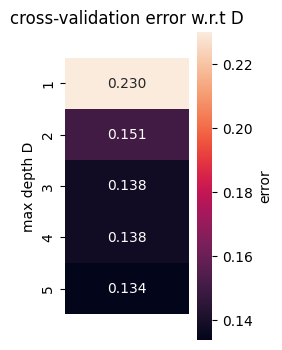

Best max depth D: 5
Test error: 0.2666666666666667
Train Accuracy: 0.9121338912133892
Validation Accuracy: 0.8659420289855072


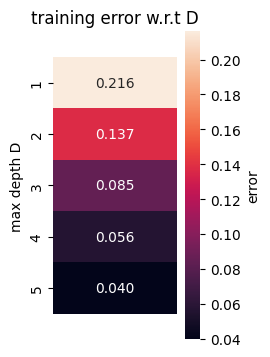

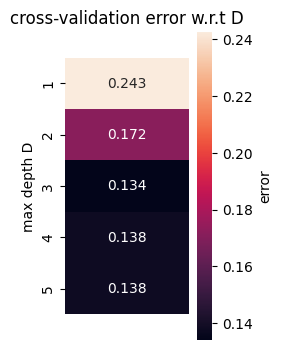

Best max depth D: 3
Test error: 0.2666666666666667


In [37]:
### Random Forests ###
RFtestAccuracy_List1=[]
RFtestAccuracy_ListOverall = []
partitions = [0.8]
RFbest_max_depth_overall = 0
RF_best_accuracy = 0
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split1X_train, Split1y_train)
        RFtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))
        

Partition: 0.8
Train Accuracy: 0.9916317991631799
Validation Accuracy: 0.874468085106383


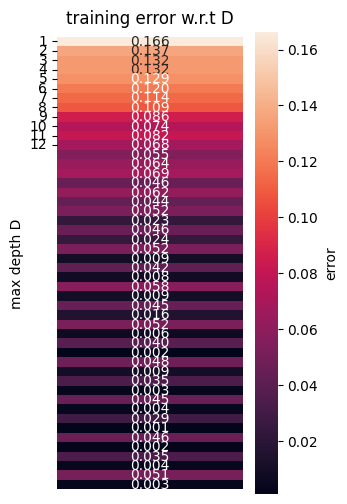

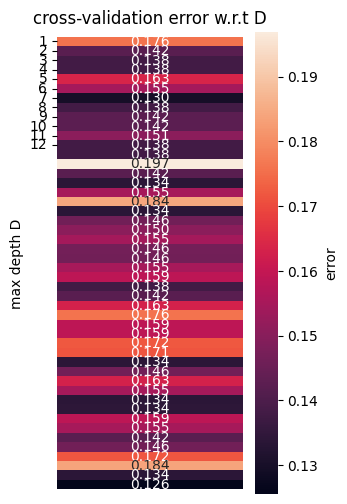

Best max depth D: 12
Test error: 0.31666666666666665
Train Accuracy: 0.9372384937238494
Validation Accuracy: 0.874645390070922


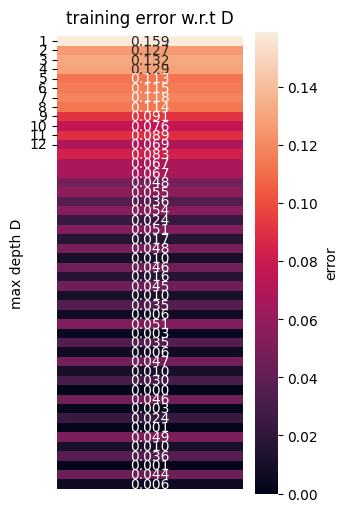

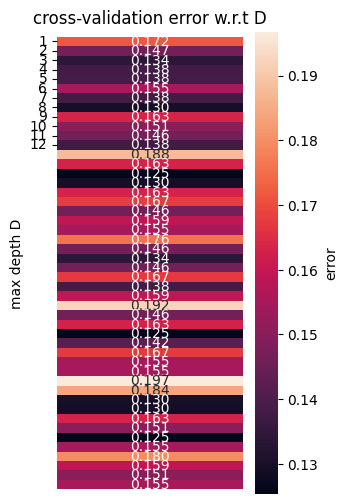

Best max depth D: 4
Test error: 0.2833333333333333
Train Accuracy: 0.9916317991631799
Validation Accuracy: 0.874645390070922


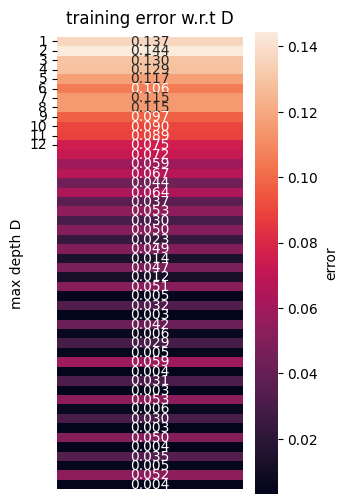

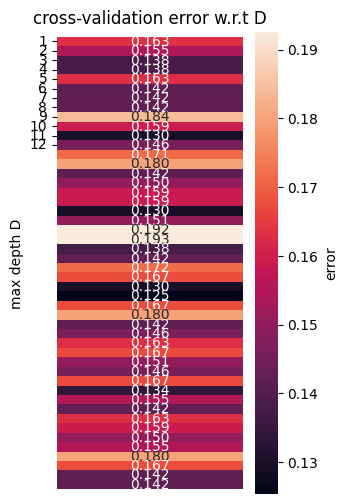

Best max depth D: 7
Test error: 0.31666666666666665


In [38]:
### Bagging family ###
BFtestAccuracy_List1=[]
BFtestAccuracy_ListOverall = []
partitions = [0.8]
BFbest_max_depth_overall = None
BF_best_accuracy = 0
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split1X_train, Split1y_train)
        BFtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))

Partition: 0.8
Best C: 1, Best Gamma: 0.001
Train Accuracy: 0.99581589958159
Validation Accuracy: 0.6988475177304965


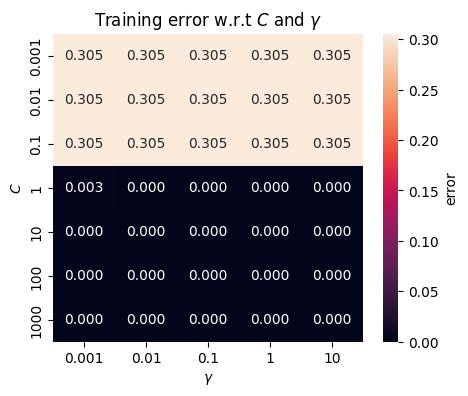

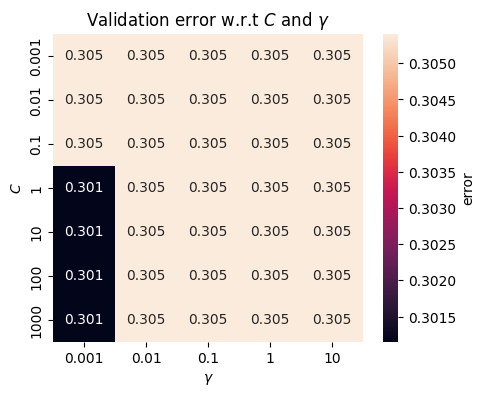

Best C: 1, Best Gamma: 0.001
Train Accuracy: 1.0
Validation Accuracy: 0.6694148936170212


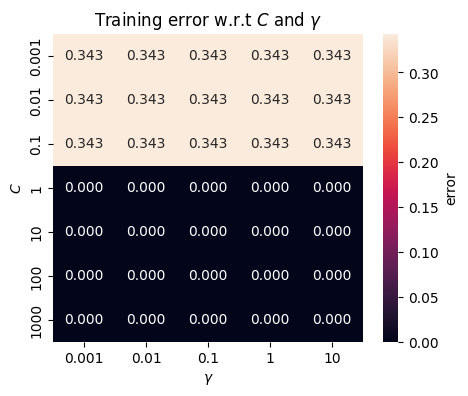

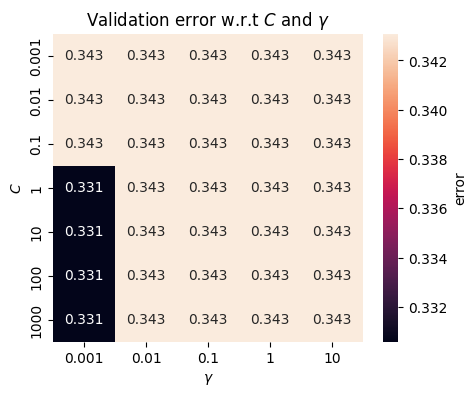

Best C: 1, Best Gamma: 0.001
Train Accuracy: 0.99581589958159
Validation Accuracy: 0.677836879432624


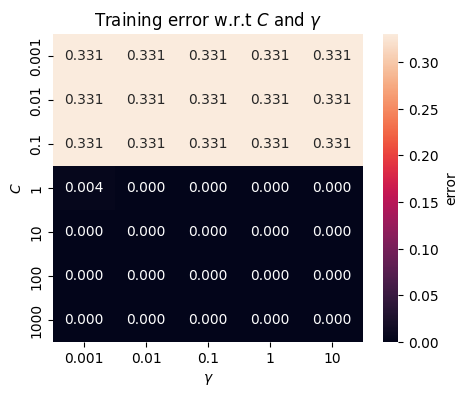

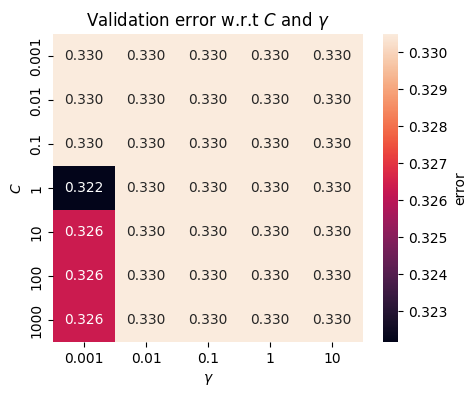

In [39]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.8]
trial = 3
testAccuracy_List1=[]
testAccuracy_ListOverall = []
training_errors = np.zeros((len(C_list), len(gamma_list)))
best_training_accuracy =0
best_C_overall = 0
best_gamma_overall = 0

#run 3 trials per partition
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split1X_train, Split1y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']


        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")

        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = classifier_Search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma


        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
    
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split1X_train, Split1y_train)
        testAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        testAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))




## Partition: 50/50 set

Partition: 0.5
Train Accuracy: 0.8322147651006712
Validation Accuracy: 0.8061904761904761


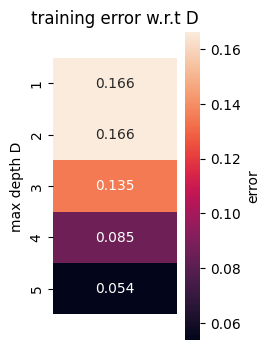

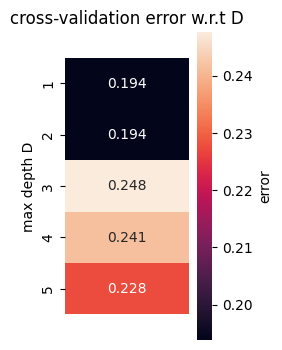

Best max depth D: 1
Test error: 0.14
Train Accuracy: 0.8523489932885906
Validation Accuracy: 0.8528571428571429


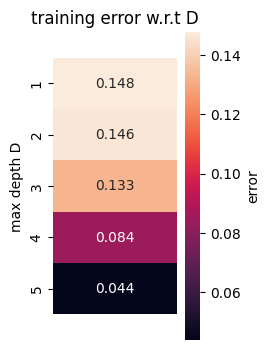

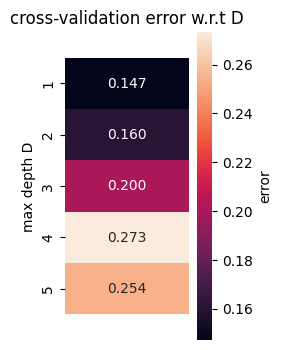

Best max depth D: 1
Test error: 0.16000000000000003
Train Accuracy: 0.7986577181208053
Validation Accuracy: 0.7785714285714286


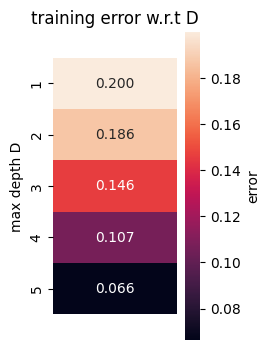

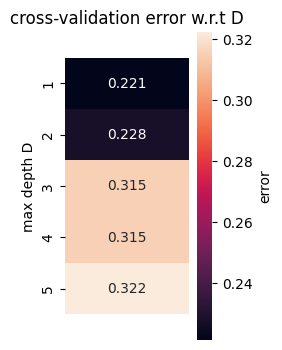

Best max depth D: 1
Test error: 0.10666666666666669


In [40]:
### Decision Tree ###
DTtestAccuracy_List2=[]
partitions = [0.5]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split2X_train, Split2y_train)
        DTtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))

Partition: 0.5
Train Accuracy: 0.9664429530201343
Validation Accuracy: 0.8928571428571429


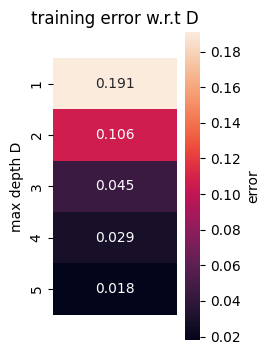

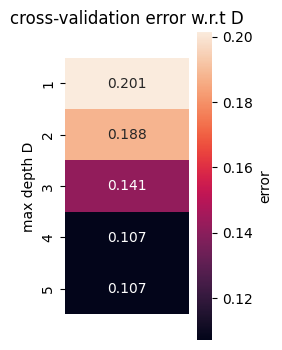

Best max depth D: 4
Test error: 0.22666666666666668
Train Accuracy: 0.959731543624161
Validation Accuracy: 0.8857142857142858


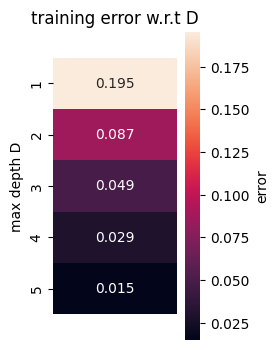

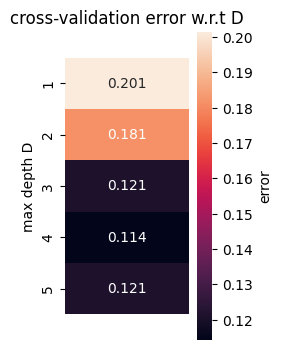

Best max depth D: 4
Test error: 0.24
Train Accuracy: 0.9798657718120806
Validation Accuracy: 0.8790476190476191


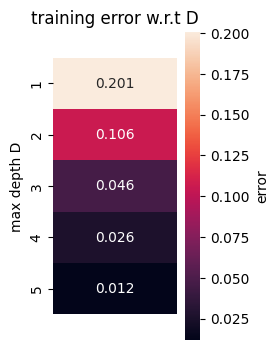

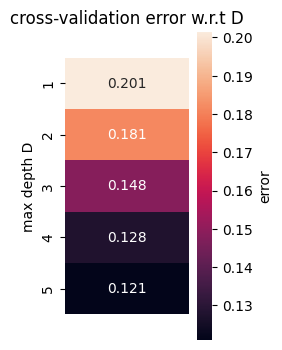

Best max depth D: 5
Test error: 0.2533333333333333


In [41]:
### Random Forests ###
RFtestAccuracy_List2=[]
partitions = [0.5]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split2X_train, Split2y_train)
        RFtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))
        

Partition: 0.5
Train Accuracy: 0.9932885906040269
Validation Accuracy: 0.8993103448275864


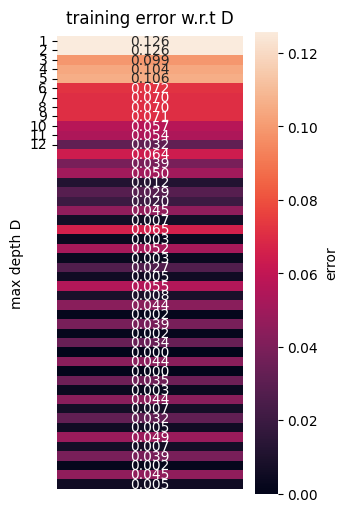

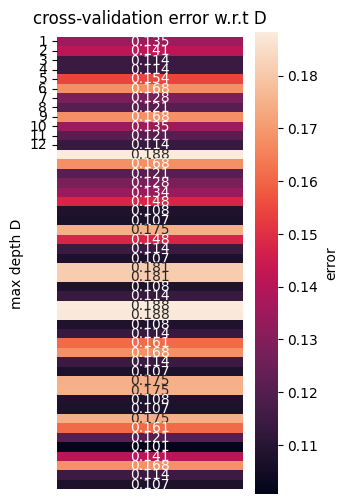

Best max depth D: 11
Test error: 0.21999999999999997
Train Accuracy: 0.959731543624161
Validation Accuracy: 0.905977011494253


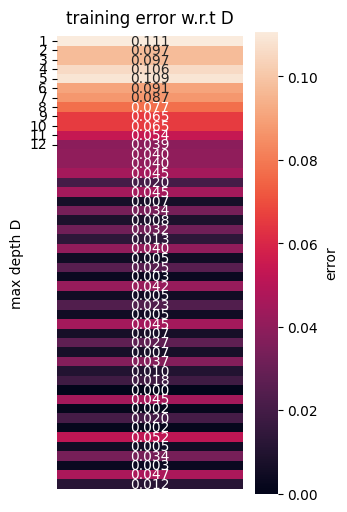

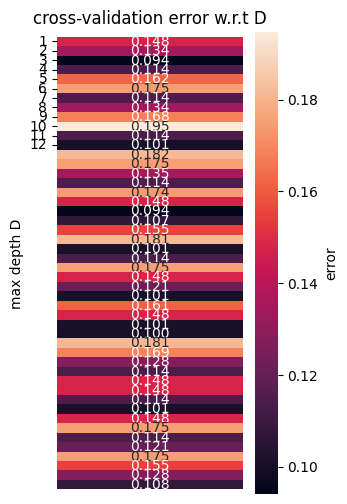

Best max depth D: 5
Test error: 0.23333333333333328
Train Accuracy: 1.0
Validation Accuracy: 0.8993103448275864


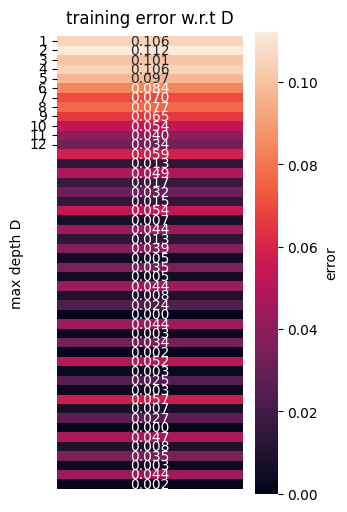

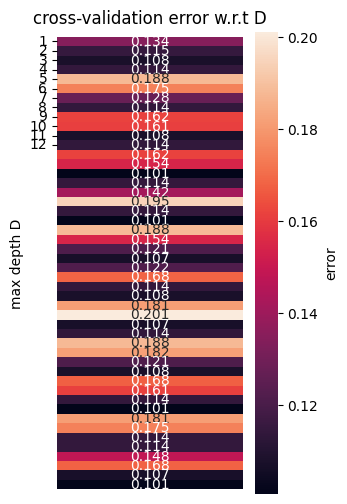

Best max depth D: 5
Test error: 0.22666666666666668


In [42]:
### Bagging family ###
BFtestAccuracy_List2=[]
partitions = [0.5]

for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split2X_train, Split2y_train)
        BFtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))

Partition: 0.5
Best C: 0.001, Best Gamma: 0.001
Train Accuracy: 0.6845637583892618
Validation Accuracy: 0.6845977011494252


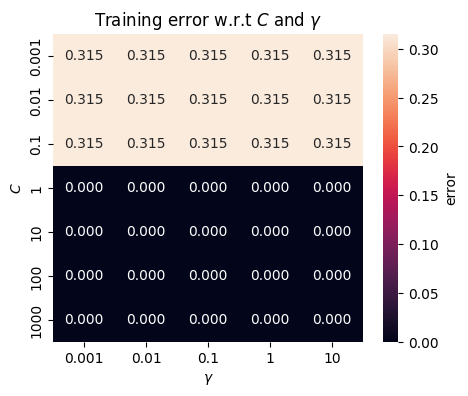

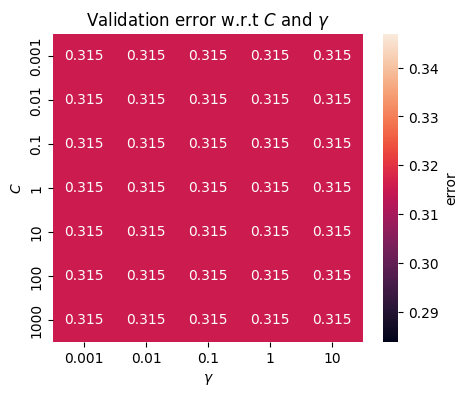

Best C: 0.001, Best Gamma: 0.001
Train Accuracy: 0.7046979865771812
Validation Accuracy: 0.7048275862068965


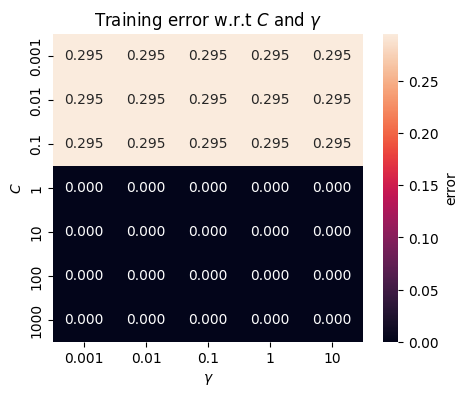

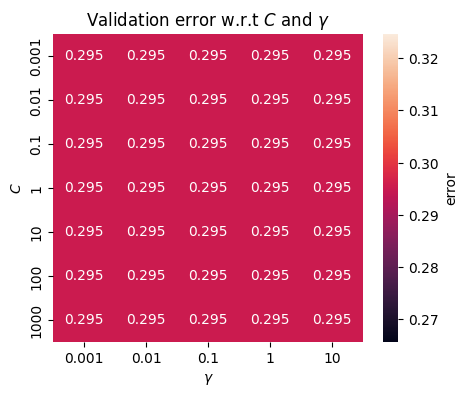

Best C: 0.001, Best Gamma: 0.001
Train Accuracy: 0.6308724832214765
Validation Accuracy: 0.6308045977011494


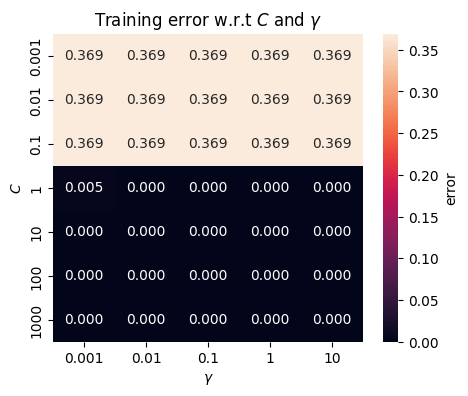

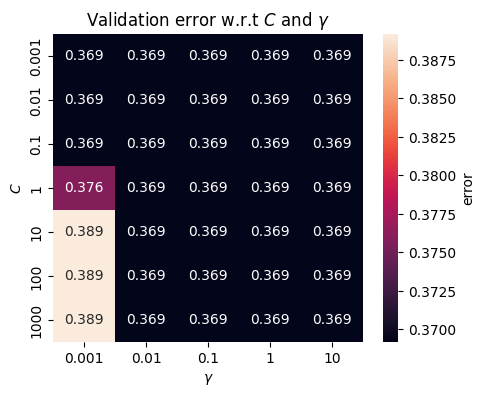

In [43]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.5]
trial = 3
testAccuracy_List2=[]
training_errors = np.zeros((len(C_list), len(gamma_list)))


#run 3 trials per partition
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=i)

        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split2X_train, Split2y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']

        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")


        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = classifier_Search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')

        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma

        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        bestC= classifier_Search.best_params_['C']
        bestGamma= classifier_Search.best_params_['gamma']
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split2X_train, Split2y_train)
        testAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        testAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))


## Partition: 20/80 set

Partition: 0.2
Train Accuracy: 0.8135593220338984
Validation Accuracy: 0.7799999999999999


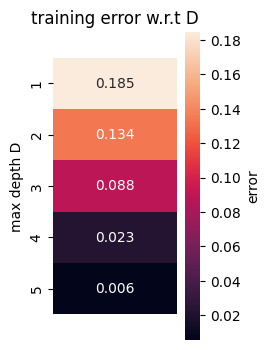

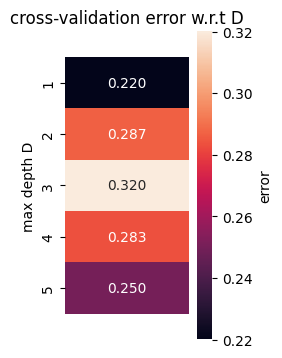

Best max depth D: 1
Test error: 0.15000000000000002
Train Accuracy: 0.8813559322033898
Validation Accuracy: 0.8300000000000001


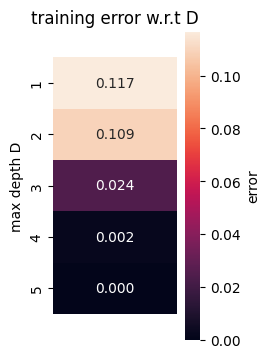

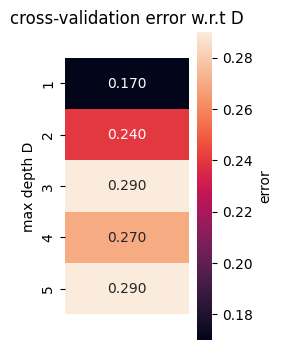

Best max depth D: 1
Test error: 0.16249999999999998
Train Accuracy: 0.9830508474576272
Validation Accuracy: 0.8466666666666667


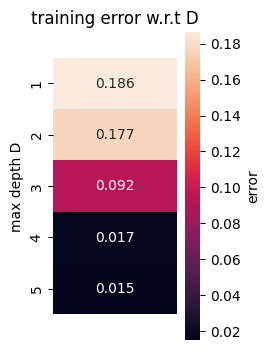

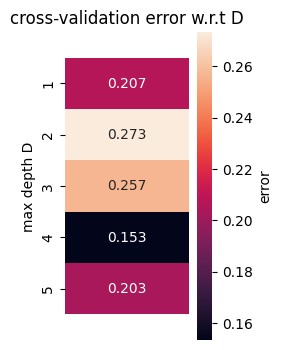

Best max depth D: 4
Test error: 0.2416666666666667


In [44]:
### Decision Tree ###
DTtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split3X_train, Split3y_train)
        DTtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))

Partition: 0.2
Train Accuracy: 1.0
Validation Accuracy: 0.85


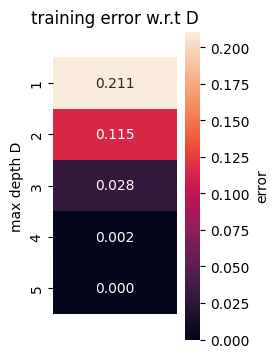

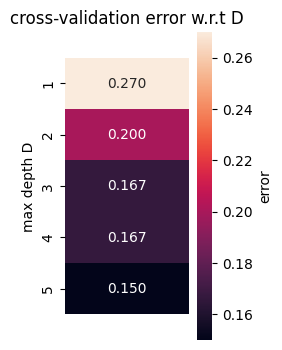

Best max depth D: 5
Test error: 0.1791666666666667
Train Accuracy: 1.0
Validation Accuracy: 0.8333333333333333


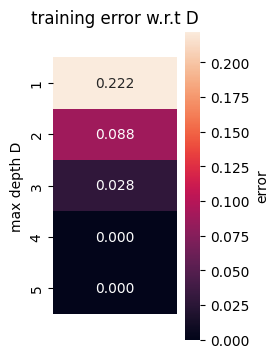

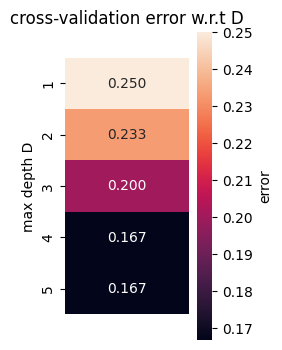

Best max depth D: 4
Test error: 0.19166666666666665
Train Accuracy: 1.0
Validation Accuracy: 0.8333333333333333


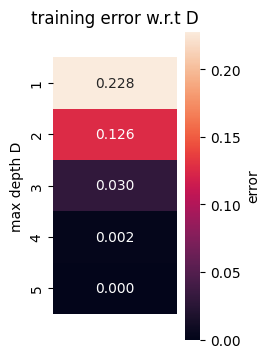

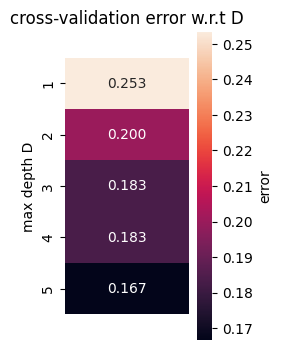

Best max depth D: 5
Test error: 0.19999999999999996


In [45]:
### Random Forests ###
RFtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split3X_train, Split3y_train)
        RFtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))
        

Partition: 0.2
Train Accuracy: 0.8813559322033898
Validation Accuracy: 0.8636363636363635


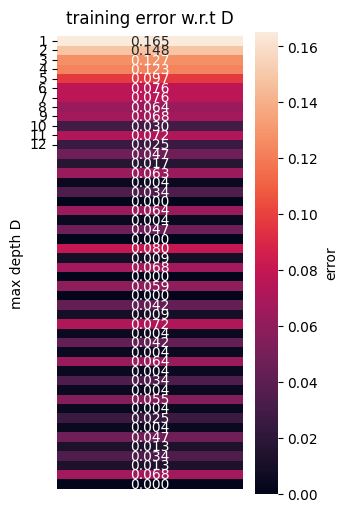

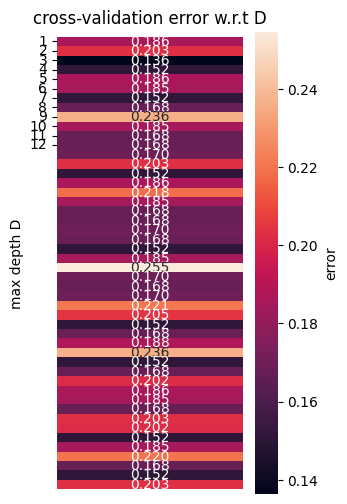

Best max depth D: 1
Test error: 0.1791666666666667
Train Accuracy: 0.8813559322033898
Validation Accuracy: 0.8484848484848484


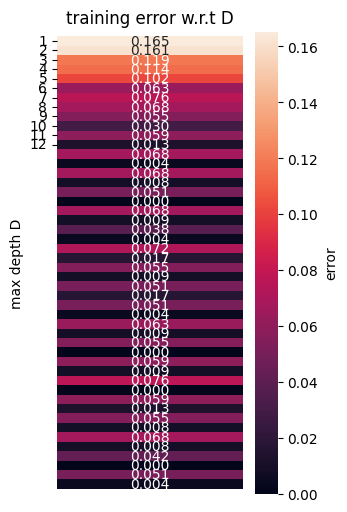

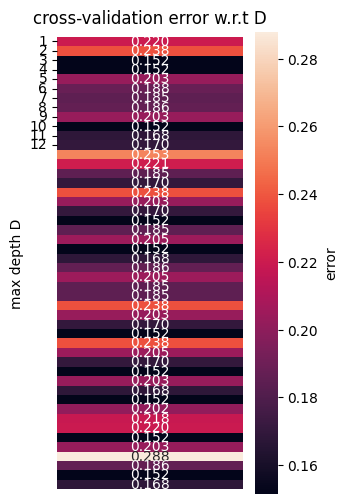

Best max depth D: 1
Test error: 0.1791666666666667
Train Accuracy: 0.8813559322033898
Validation Accuracy: 0.8818181818181816


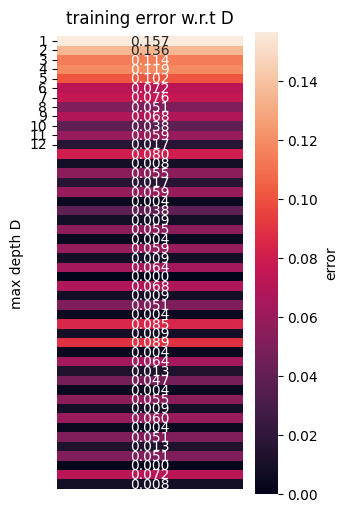

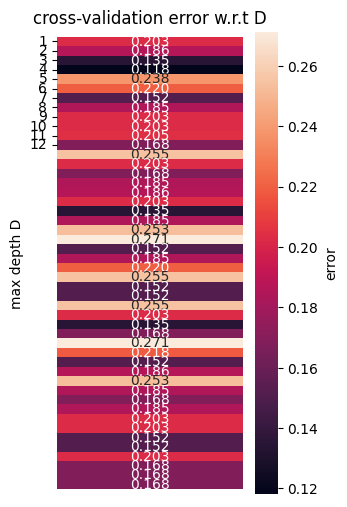

Best max depth D: 1
Test error: 0.18333333333333335


In [46]:
### Bagging family ###
BFtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split2X_train, Split2y_train)
        BFtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))

Partition: 0.2
Best C: 0.001, Best Gamma: 0.001
Train Accuracy: 0.6271186440677966
Validation Accuracy: 0.6272727272727272


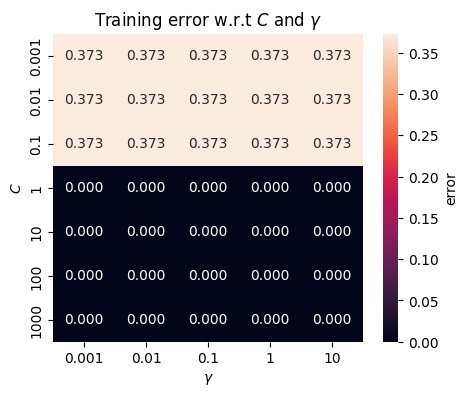

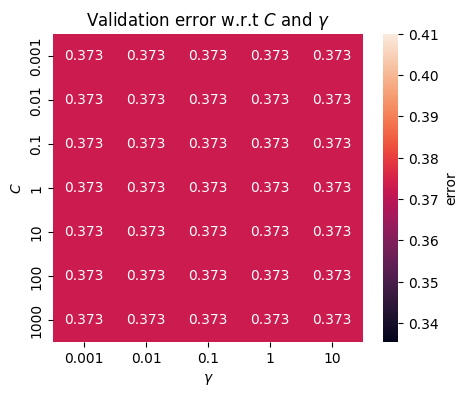

Best C: 0.001, Best Gamma: 0.001
Train Accuracy: 0.711864406779661
Validation Accuracy: 0.7121212121212122


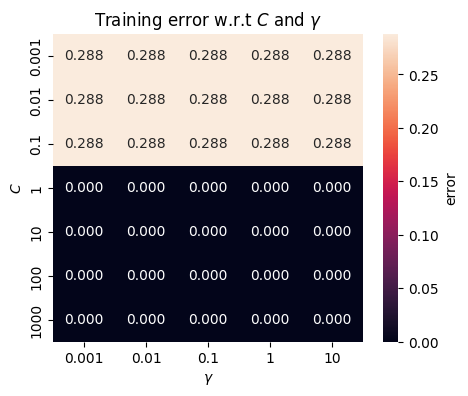

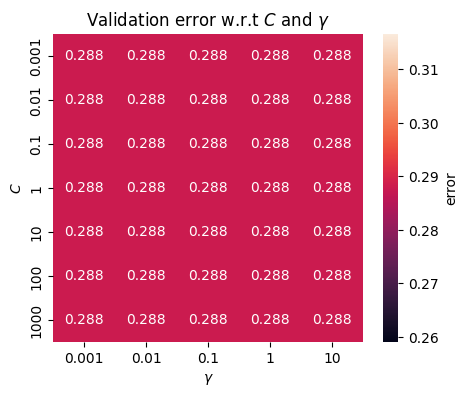

Best C: 0.001, Best Gamma: 0.001
Train Accuracy: 0.6271186440677966
Validation Accuracy: 0.6272727272727272


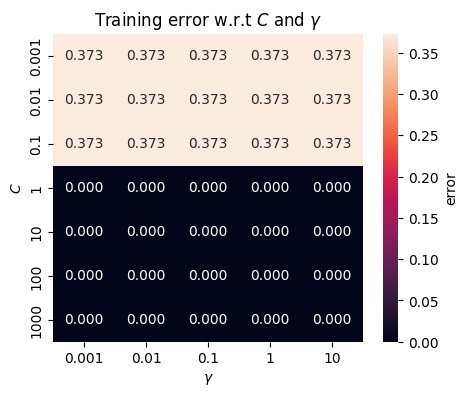

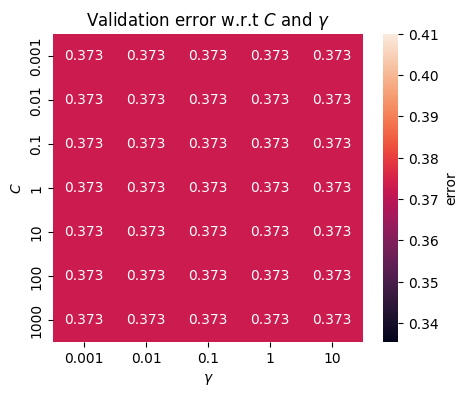

In [47]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.2]
trial = 3
testAccuracy_List3=[]
training_errors = np.zeros((len(C_list), len(gamma_list)))


#run 3 trials per partition
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=i)

        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split3X_train, Split3y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']

        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")

        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = classifier_Search.best_score_


        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma

        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split3X_train, Split3y_train)
        testAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))
        testAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))


## Best training accuracy with optimal Hyperparameter

In [48]:
### Report best training accuracies with their optimal hyperparameters. ###
print(f'Best training accuracy for Decision Tree: {DT_best_accuracy} with optimal hyperparameter D:{DTbest_max_depth_overall}.')
print(f'Best training accuracy for Random Forests: {RF_best_accuracy} with optimal hyperparameter D:{RFbest_max_depth_overall}.')
print(f'Best training accuracy for Bagging family: {BF_best_accuracy} with optimal hyperparameter D:{BFbest_max_depth_overall}.')
print(f'Best training accuracy for SVM w/RBF: {best_training_accuracy} with optimal hyperparameter C:{best_C_overall} and gamma:{best_gamma_overall}')

Best training accuracy for Decision Tree: 0.9830508474576272 with optimal hyperparameter D:4.
Best training accuracy for Random Forests: 1.0 with optimal hyperparameter D:5.
Best training accuracy for Bagging family: 1.0 with optimal hyperparameter D:5.
Best training accuracy for SVM w/RBF: 1.0 with optimal hyperparameter C:1 and gamma:0.001


## Report test data respective average accuracy.

In [49]:
### Decision Tree ###
print(f'The average of the test accuracies for Decision Tree is: {sum(DTtestAccuracy_ListOverall) / len(DTtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for  80/20 split Decision Tree is: {sum(DTtestAccuracy_List1) / len(DTtestAccuracy_List1)}')
print(f'The average of the test accuracies for  50/50 split Decision Tree is: {sum(DTtestAccuracy_List2) / len(DTtestAccuracy_List2)}')
print(f'The average of the test accuracies for  20/80 split Decision Tree is: {sum(DTtestAccuracy_List3) / len(DTtestAccuracy_List3)}')

The average of the test accuracies for Decision Tree is: 0.8450925925925925
The average of the test accuracies for  80/20 split Decision Tree is: 0.8611111111111112
The average of the test accuracies for  50/50 split Decision Tree is: 0.8644444444444445
The average of the test accuracies for  20/80 split Decision Tree is: 0.8097222222222222


In [50]:
### Random Forests ###
print(f'The average of the test accuracies for Random Forests is: {sum(RFtestAccuracy_ListOverall) / len(RFtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 Random Forests is: {sum(RFtestAccuracy_List1) / len(RFtestAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 Random Forests is: {sum(RFtestAccuracy_List2) / len(RFtestAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 Random Forests is: {sum(RFtestAccuracy_List3) / len(RFtestAccuracy_List3)}')

The average of the test accuracies for Random Forests is: 0.7771296296296297
The average of the test accuracies for 80/20 Random Forests is: 0.75
The average of the test accuracies for 50/50 Random Forests is: 0.7688888888888888
The average of the test accuracies for 20/80 Random Forests is: 0.8125


In [51]:
### Bagging family ### 
print(f'The average of the test accuracies for Bagging family is: {sum(BFtestAccuracy_ListOverall) / len(BFtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 Bagging family is: {sum(BFtestAccuracy_List1) / len(BFtestAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 Bagging family is: {sum(BFtestAccuracy_List2) / len(BFtestAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 Bagging family is: {sum(BFtestAccuracy_List3) / len(BFtestAccuracy_List3)}')

The average of the test accuracies for Bagging family is: 0.7999074074074075
The average of the test accuracies for 80/20 Bagging family is: 0.7388888888888889
The average of the test accuracies for 50/50 Bagging family is: 0.7622222222222222
The average of the test accuracies for 20/80 Bagging family is: 0.8986111111111111


In [52]:
### SVM w/RBF kernel ###
print(f'The average of the test accuracies for SVM w/RBF is: {sum(testAccuracy_ListOverall) / len(testAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 split SVM w/RBF is: {sum(testAccuracy_List1) / len(testAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 split SVM w/RBF is: {sum(testAccuracy_List2) / len(testAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 split SVM w/RBF is: {sum(testAccuracy_List3) / len(testAccuracy_List3)}')

The average of the test accuracies for SVM w/RBF is: 0.6929629629629629
The average of the test accuracies for 80/20 split SVM w/RBF is: 0.7055555555555556
The average of the test accuracies for 50/50 split SVM w/RBF is: 0.6844444444444444
The average of the test accuracies for 20/80 split SVM w/RBF is: 0.6888888888888888
